# Point Patterns

> [`IPYNB`](../content/part2/04_points.ipynb)

This notebook covers a brief introduction on how to visualize and analyze point patterns. To demonstrate this, we will use a dataset of all the AirBnb listings in the city of Austin (check the Data section for more information about the dataset).

Before anything, let us load up the libraries we will use:

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import mplleaflet as mpll

/home/dani/anaconda/envs/pydata/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Data preparation

Let us first set the paths to the datasets we will be using:

In [50]:
# Adjust this to point to the right file in your computer
listings_link = '../data/listings.csv.gz'

The core dataset we will use is `listings.csv`, which contains a lot of information about each individual location listed at AirBnb within Austin:

In [51]:
lst = pd.read_csv(listings_link)
lst.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5835 entries, 0 to 5834
Data columns (total 92 columns):
id                                  5835 non-null int64
listing_url                         5835 non-null object
scrape_id                           5835 non-null int64
last_scraped                        5835 non-null object
name                                5835 non-null object
summary                             5373 non-null object
space                               4475 non-null object
description                         5832 non-null object
experiences_offered                 5835 non-null object
neighborhood_overview               3572 non-null object
notes                               2413 non-null object
transit                             3492 non-null object
thumbnail_url                       5542 non-null object
medium_url                          5542 non-null object
picture_url                         5835 non-null object
xl_picture_url                      5542

It turns out that one record displays a very odd location and, for the sake of the illustration, we will remove it:

In [4]:
odd = lst.loc[lst.longitude>-80, ['longitude', 'latitude']]
odd

,longitude,latitude
5832,-5.093682,43.214991


In [5]:
lst = lst.drop(odd.index)

## Point Visualization

The most straighforward way to get a first glimpse of the distribution of the data is to plot their latitude and longitude:

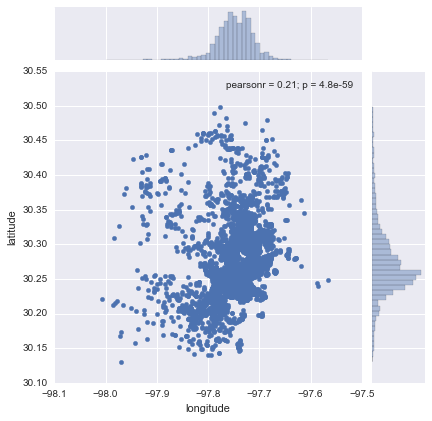

In [6]:
sns.jointplot(x="longitude", y="latitude", data=lst);

Now this does not neccesarily tell us much about the dataset or the distribution of locations within Austin. There are two main challenges in interpreting the plot: one, there is lack of context, which means the points are not identifiable over space (unless you are so familiar with lon/lat pairs that they have a clear meaning to you); and two, in the center of the plot, there are so many points that it is hard to tell any patter other than a big blurb of blue.

Let us first focus on the first problem, geographical context. The quickest and easiest way to provide context to this set of points is to overlay a general map. If we had an image with the map or a set of several data sources that we could aggregate to create a map, we could build it from scratch. But in the XXI Century, the easiest is to overlay our point dataset on top of a web map. In this case, we will use [Leaflet](http://leafletjs.com/), and we will convert our underlying `matplotlib` points with `mplleaflet`. The full dataset (+5k observations) is a bit too much for leaflet to plot it directly on screen, so we will obtain a random sample of 100 points:

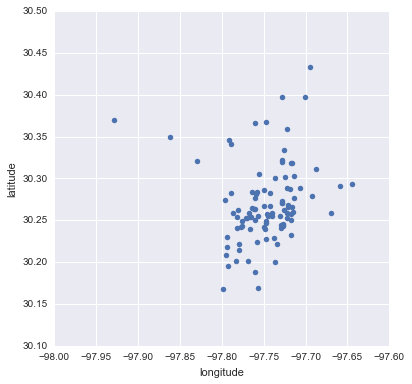

In [59]:
# NOTE: `mpll.display` turned off to be able to compile the website,
#       comment out the last line of this cell for rendering Leaflet map.
rids = np.arange(lst.shape[0])
np.random.shuffle(rids)
f, ax = plt.subplots(1, figsize=(6, 6))
lst.iloc[rids[:100], :].plot(kind='scatter', x='longitude', y='latitude', \
                      s=30, linewidth=0, ax=ax);
#mpll.display(fig=f,)

This map allows us to get a much better sense of where the points are and what type of location they might be in. For example, now we can see that the bigh blue blurb has to do with the urbanized core of Austin.

### `bokeh` alternative

Leaflet is not the only technology to display data on maps, although it is probably the default option in many cases. When the data is larger than "acceptable", we need to resort to more technically sophisticated alternatives. One option is provided by `bokeh` and its `datashaded` submodule (see [here](https://anaconda.org/jbednar/nyc_taxi/notebook) for a very nice introduction to the library, from where this example has been adapted).

Before we delve into `bokeh`, let us reproject our original data (lon/lat coordinates) into Web Mercator, as `bokeh` will expect them. To do that, we turn the coordinates into a `GeoSeries`:

In [8]:
from shapely.geometry import Point
xys_wb = gpd.GeoSeries(lst[['longitude', 'latitude']].apply(Point, axis=1), \
                      crs="+init=epsg:4326")
xys_wb = xys_wb.to_crs(epsg=3857)
x_wb = xys_wb.apply(lambda i: i.x)
y_wb = xys_wb.apply(lambda i: i.y)

Now we are ready to setup the plot in `bokeh`:

In [9]:
from bokeh.plotting import figure, output_notebook, show
from bokeh.tile_providers import STAMEN_TERRAIN
output_notebook()

minx, miny, maxx, maxy = xys_wb.total_bounds
y_range = miny, maxy
x_range = minx, maxx

def base_plot(tools='pan,wheel_zoom,reset',plot_width=600, plot_height=400, **plot_args):
    p = figure(tools=tools, plot_width=plot_width, plot_height=plot_height,
        x_range=x_range, y_range=y_range, outline_line_color=None,
        min_border=0, min_border_left=0, min_border_right=0,
        min_border_top=0, min_border_bottom=0, **plot_args)
    
    p.axis.visible = False
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    return p
    
options = dict(line_color=None, fill_color='#800080', size=4)

Loading BokehJS ...

And good to go for mapping!

In [52]:
# NOTE: `show` turned off to be able to compile the website,
#       comment out the last line of this cell for rendering.
p = base_plot()
p.add_tile(STAMEN_TERRAIN)
p.circle(x=x_wb, y=y_wb, **options)
#show(p)

As you can quickly see, `bokeh` is substantially faster at rendering larger amounts of data.

The second problem we have spotted with the first scatter is that, when the number of points grows, at some point it becomes impossible to discern anything other than a big blur of color. To some extent, interactivity gets at that problem by allowing the user to zoom in until every point is an entity on its own. However, there exist techniques that allow to summarize the data to be able to capture the overall pattern at once. Traditionally, kernel density estimation (KDE) has been one of the most common solutions by approximating a continuous surface of point intensity. In this context, however, we will explore a more recent alternative suggested by the [`datashader`](https://github.com/bokeh/datashader) library (see the [paper](http://www.crest.iu.edu/publications/prints/2014/Cottam2014OutOfCore.pdf) if interested in more details).

Arguably, our dataset is not large enough to justify the use of a reduction technique like datashader, but we will create the plot for the sake of the illustration. Keep in mind, the usefulness of this approach increases the more points you need to be plotting.

In [36]:
# NOTE: `show` turned off to be able to compile the website,
#       comment out the last line of this cell for rendering.

import datashader as ds
from datashader.callbacks import InteractiveImage
from datashader.colors import viridis
from datashader import transfer_functions as tf
from bokeh.tile_providers import STAMEN_TONER

p = base_plot()
p.add_tile(STAMEN_TONER)

pts = pd.DataFrame({'x': x_wb, 'y': y_wb})
pts['count'] = 1
def create_image90(x_range, y_range, w, h):
    cvs = ds.Canvas(plot_width=w, plot_height=h, x_range=x_range, y_range=y_range)
    agg = cvs.points(pts, 'x', 'y',  ds.count('count'))
    img = tf.interpolate(agg.where(agg > np.percentile(agg,90)), \
                         cmap=viridis, how='eq_hist')
    return tf.dynspread(img, threshold=0.1, max_px=4)
    
#InteractiveImage(p, create_image90)

The key advandage of `datashader` is that is decouples the point processing from the plotting. That is the bit that allows it to be scalable to truly large datasets (e.g. millions of points). Essentially, the approach is based on generating a very fine grid, counting points within pixels, and encoding the count into a color scheme. In our map, this is not particularly effective because we do not have too many points (the previous plot is probably a more effective one) and esssentially there is a pixel per location of every point. However, hopefully this example shows how to create this kind of scalable maps.

## Centrography and distance based statistics

## Exercise

> *Split the dataset by type of property and create a map for the five most common types.*

Consider the following sorting of property types:

In [46]:
lst.property_type.groupby(lst.property_type)\
                 .count()\
                 .sort_values(ascending=False)

property_type
House              3549
Apartment          1855
Condominium         106
Loft                 83
Townhouse            57
Other                47
Bed & Breakfast      37
Camper/RV            34
Bungalow             18
Cabin                17
Tent                 11
Villa                 7
Treehouse             7
Earth House           2
Chalet                1
Hut                   1
Boat                  1
Tipi                  1
Name: property_type, dtype: int64